# Question 1: Which states are most similar in terms of their national park type distribution?

We can create vectors for each state based on the type and quantity of national parks they have (National Historic Monument, National Lakeshore, etc). We can create a network of the states by calculating pairwise similarity of the vectors, where each node is a state/region and the edges are weighted by similarity. Then we complete a network analysis of the state nodes to find the state with highest between-
ness, closeness centrality, etc.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


To start, let's read in the time series data.

In [27]:
visit_data = pd.read_csv('timeseries_data.csv',index_col='Unnamed: 0')
visit_data['date'] = pd.to_datetime(visit_data['date'], infer_datetime_format=True)
print('The shape is: ',visit_data.shape)
print('The columns are: ',visit_data.columns)
print('The visit types are: ',visit_data['visit_type'].unique())

The shape is:  (1026608, 8)
The columns are:  Index(['ParkName', 'UnitCode', 'ParkType', 'Region', 'state_2', 'date',
       'visit_type', 'number_of_visits'],
      dtype='object')
The visit types are:  ['RecreationVisits' 'NonRecreationVisits' 'RecreationHours'
 'NonRecreationHours' 'ConcessionerLodging' 'ConcessionerCamping'
 'TentCampers' 'RVCampers' 'Backcountry' 'NonRecreationOvernightStays'
 'MiscellaneousOvernightStays']


Let's start by looking at a few of the most popular parks.

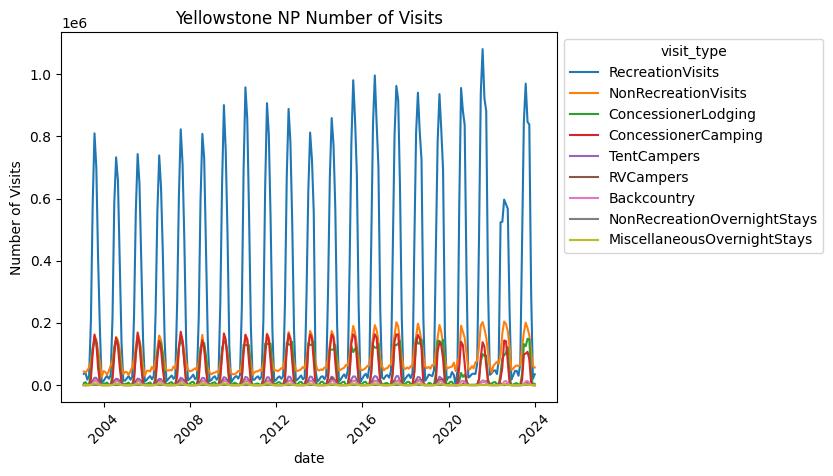

In [41]:
yellowstone_only = visit_data[visit_data.ParkName.str.contains('Yellowstone')]
# don't want to look at hours, want to do only visits
yellowstone_only = yellowstone_only[yellowstone_only.visit_type.isin(['RecreationVisits', 'NonRecreationVisits', 'ConcessionerLodging', 'ConcessionerCamping',
       'TentCampers', 'RVCampers', 'Backcountry',
       'NonRecreationOvernightStays', 'MiscellaneousOvernightStays'])]
ax = sns.lineplot(yellowstone_only,x='date',y='number_of_visits',hue='visit_type')
plt.title('Yellowstone NP Number of Visits')
plt.ylabel('Number of Visits')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
_ = plt.tick_params(axis='x',rotation=45)

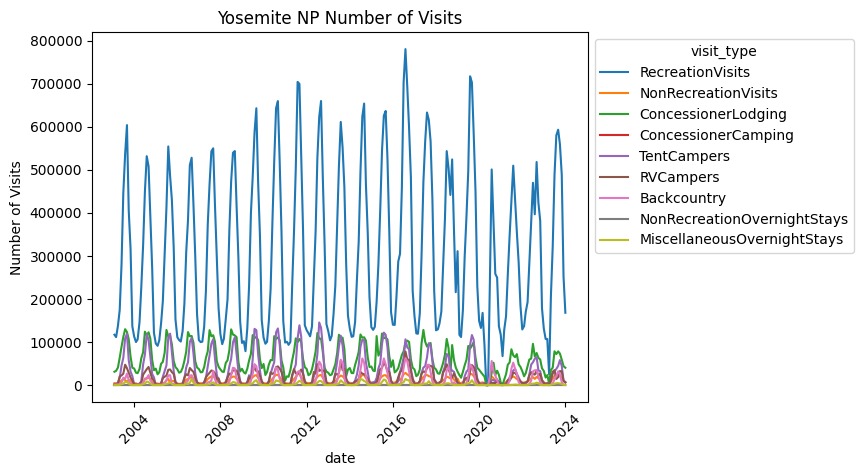

In [44]:
yellowstone_only = visit_data[visit_data.ParkName.str.contains('Yosemite')]
# don't want to look at hours, want to do only visits
yellowstone_only = yellowstone_only[yellowstone_only.visit_type.isin(['RecreationVisits', 'NonRecreationVisits', 'ConcessionerLodging', 'ConcessionerCamping',
       'TentCampers', 'RVCampers', 'Backcountry',
       'NonRecreationOvernightStays', 'MiscellaneousOvernightStays'])]
ax = sns.lineplot(yellowstone_only,x='date',y='number_of_visits',hue='visit_type')
plt.title('Yosemite NP Number of Visits')
plt.ylabel('Number of Visits')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
_ = plt.tick_params(axis='x',rotation=45)

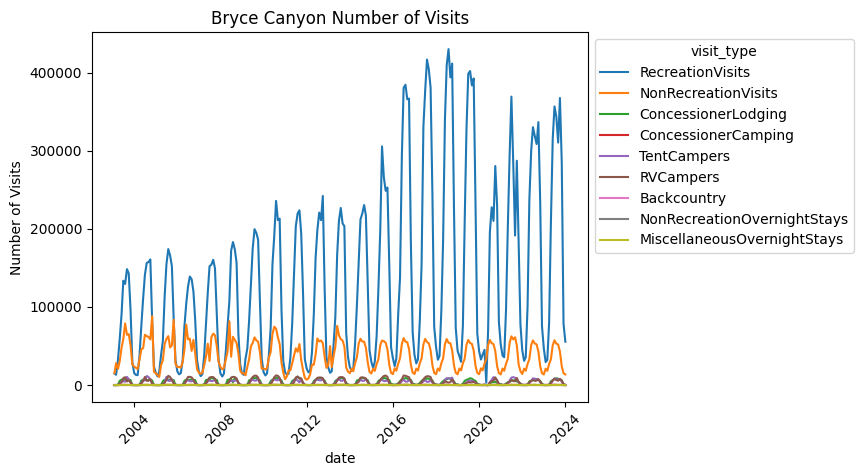

In [45]:
yellowstone_only = visit_data[visit_data.ParkName.str.contains('Bryce')]
# don't want to look at hours, want to do only visits
yellowstone_only = yellowstone_only[yellowstone_only.visit_type.isin(['RecreationVisits', 'NonRecreationVisits', 'ConcessionerLodging', 'ConcessionerCamping',
       'TentCampers', 'RVCampers', 'Backcountry',
       'NonRecreationOvernightStays', 'MiscellaneousOvernightStays'])]
ax = sns.lineplot(yellowstone_only,x='date',y='number_of_visits',hue='visit_type')
plt.title('Bryce Canyon Number of Visits')
plt.ylabel('Number of Visits')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
_ = plt.tick_params(axis='x',rotation=45)

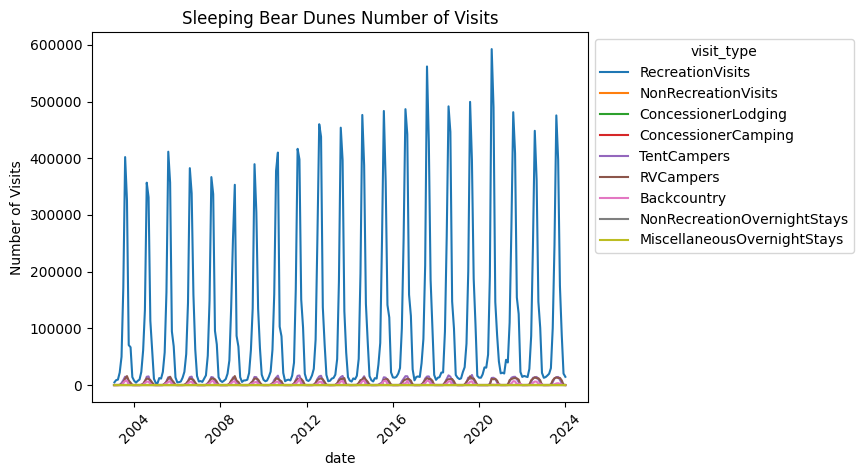

In [47]:
yellowstone_only = visit_data[visit_data.ParkName.str.contains('Sleeping Bear')]
# don't want to look at hours, want to do only visits
yellowstone_only = yellowstone_only[yellowstone_only.visit_type.isin(['RecreationVisits', 'NonRecreationVisits', 'ConcessionerLodging', 'ConcessionerCamping',
       'TentCampers', 'RVCampers', 'Backcountry',
       'NonRecreationOvernightStays', 'MiscellaneousOvernightStays'])]
ax = sns.lineplot(yellowstone_only,x='date',y='number_of_visits',hue='visit_type')
plt.title('Sleeping Bear Dunes Number of Visits')
plt.ylabel('Number of Visits')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
_ = plt.tick_params(axis='x',rotation=45)

We can already start to see the different seasonal patterns that are emerging. Now let's look at a few states.

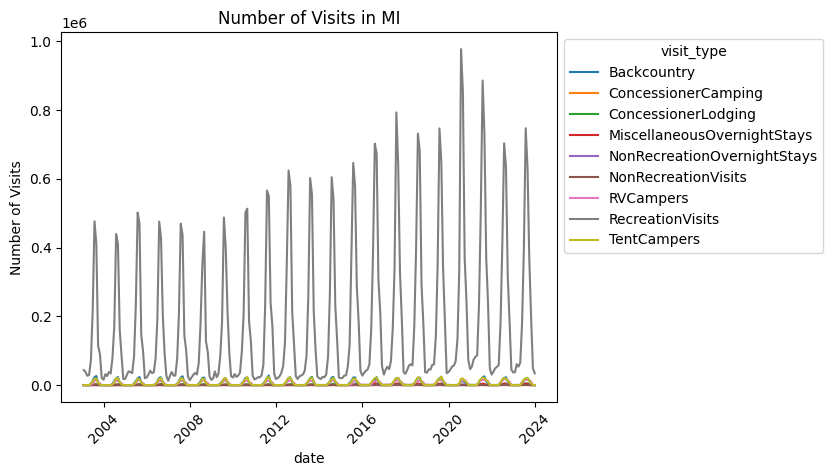

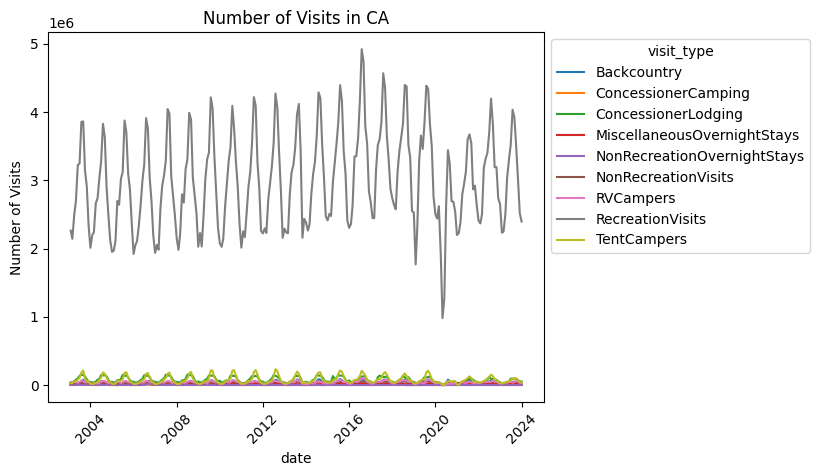

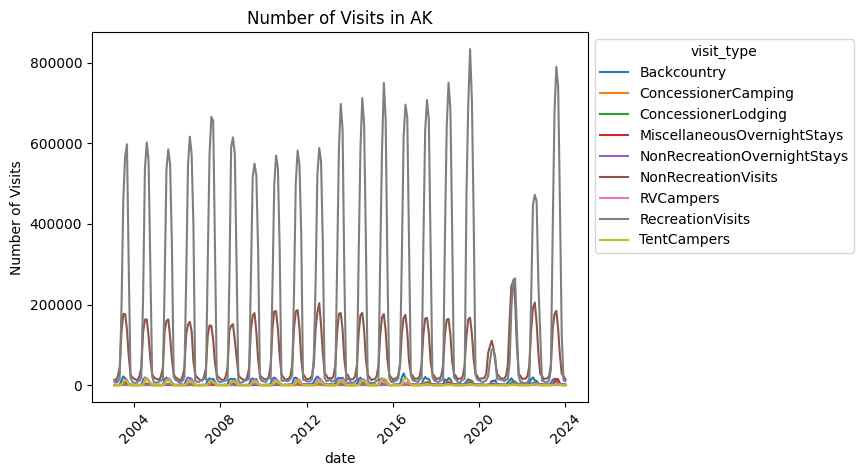

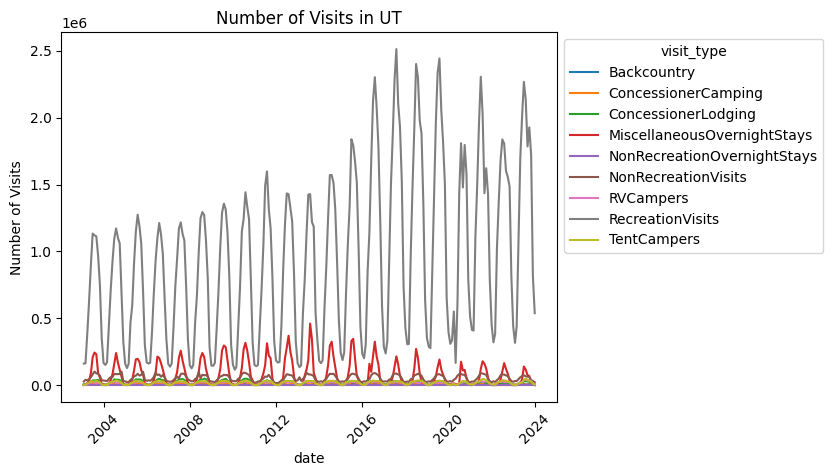

In [63]:
# picking my favorite states 
states = ['MI','CA','AK','UT']
for st in states:
    state_only = visit_data[visit_data.state_2 == st]
    cols = ['RecreationVisits', 'NonRecreationVisits', 'ConcessionerLodging', 'ConcessionerCamping',
        'TentCampers', 'RVCampers', 'Backcountry',
        'NonRecreationOvernightStays', 'MiscellaneousOvernightStays']
    # don't want to look at hours, want to do only visits
    state_only = state_only[state_only.visit_type.isin(cols)]
    #group across all parks
    state_only = state_only.groupby(['state_2','date','visit_type']).sum()['number_of_visits'].reset_index()
    ax = sns.lineplot(state_only,x='date',y='number_of_visits',hue='visit_type')
    plt.title(f'Number of Visits in {st}')
    plt.ylabel('Number of Visits')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    _ = plt.tick_params(axis='x',rotation=45)
    plt.show()